# Linear ops: What and Why?

## Mathematical Definition

In this section we'll define and motivate the use of linear ops. You'll find this content extremely useful if you have little to no prior experience on these topics. We'll first formally define a linear operator but we'll swiftly move from the abstract formulation to a motivating example based on a simple Physics application.

Mathematically, a linear operator is a function $T:V \to W$ that maps elements from the vector space $V$ onto the vector space $W$ such that it is linear, that is, $T(\alpha x + y) = \alpha T(x) + T(y)$.
One commmon example is a matrix $A \in \mathbb{R}^{n \times n}$ which basically maps vectors in $\mathbb{R}^{n}$ to vectors in $\mathbb{R}^{n}$. Another example is the differentiable operator $D:C^{1} \to C^{1}$ which maps a differentiable function $f$ to its derivative, that is $D[f] = \frac{d}{dx} f$.

Going back to our matrix example, we are used to representing this linear operator as an array of $O(n^2)$ numbers. This represention allows us not only to easily compute $Av$ through matrix-vector mulitplication but also to factorize the matrix (like the Cholesky decomposition) allowing us to solve linear systems $Ax=b$ or compute log-determinants $\log |A|$. However, as we increase the size of the matrix, its dense array representation rapidly becomes computationally infeasible: we'll run out of RAM memory.
Worse, this dense representation is wasteful as we cannot take advantage of sparsity in the matrix (think of a diagonal matrix, where we still have to use $O(n^2)$ elements when only $O(n)$ are nonzero), and the standard algorithms that manipulate elements of the matrix have large runtimes (for example, the Choleskly decomposition is $O(n^3)$).

A scalable alternative to the dense representation of $A$ is to simply define a function that expresses $v \mapsto Av$ in a more economical fashion. For example, if the matrix is diagional $A=\text{diag}(a)$ then we can simply define $v \mapsto Av$ as $v \mapsto a \odot v$, where $\odot$ stands for element-wise multiplication. For a given $a$, in code the function would look like

In [1]:
from jax import numpy as jnp

a = jnp.array([1., 2., 3.])

def A_diag(v):
    return a * v

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


This is great as $A$ can now be represented by a vector $a$ with $O(n)$ entries and a matrix-vector multipy (MVM) only takes $O(n)$ and not $O(n^2)$ computations to run. However, as we don't have a dense representation of $A$, we cannot longer apply the usual algorithms that manipulate matrix entries (Gaussian elimination, Cholesky decomposition, etc).
Luckly, there is a set of algorithms that only require access to the $A$ through MVMs.
These algorithms are categorized as Krylov subspace methods where notable examples are conjugate gradients (CG), Lanczos, Arnoldi and generalized minimum residual (GMRES).

## Example: Two-value boundary value problem

In this next example we'll illustrate how strucutre naturally occurs in many applications and how we can take advantage of it by using linear ops.
We'll start by trying to solve a two-point boundary value problem. Assume that for the interval $[0, 1]$ we are trying to find a function $y:[0, 1] \to \mathbb{R}$ such that $y^{\prime \prime}(t) = f(t)$ for a known function $f:[0, 1] \to \mathbb{R}$ and we also know that $y(0) = 0$ and $y(1) = 0$. Using a centered Taylor expansion we know that 
$y^{\prime \prime}(t) \approx \frac{y(t - h) - 2y(t) + y(t + h)}{h^2}$
is a good approximation for a sufficienty small $h$. By letting $h= \frac{1}{n+1}$ we can find $y$ by solving the following linear system.
$$
\begin{bmatrix}
-2 & 1 & 0 & 0 & \cdots & 0 & 0 \\
1 & -2 & 1 & 0 & \cdots & 0 & 0  \\
0 & 1 & -2 & 1 & \cdots & 0 & 0 \\
\vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots \\
0 & 0 & 0 & 0 & \cdots & -2 & 1 \\
\end{bmatrix}
\begin{bmatrix} y_1 \\ y_2 \\ y_3 \\ \vdots \\ y_n \end{bmatrix}
=
h^{2}
\begin{bmatrix} f_1 \\ f_2 \\ f_3 \\ \vdots \\ f_n \end{bmatrix}.
$$
The usual procedure to solve this problem would be to run the following code. Lets suppose that $f(t) = 5t$.

In [2]:
def f(t):
    return 5 * t


def dense_tridiagional_two_points(N):
    A = jnp.zeros((N, N))
    for idx in range(N):
        for jdx in range(N):
            if idx == jdx:
                A = A.at[idx, jdx].set(-2)
            elif idx == jdx + 1:
                A = A.at[idx, jdx].set(1)
            elif idx == jdx - 1:
                A = A.at[idx, jdx].set(1)
    return A

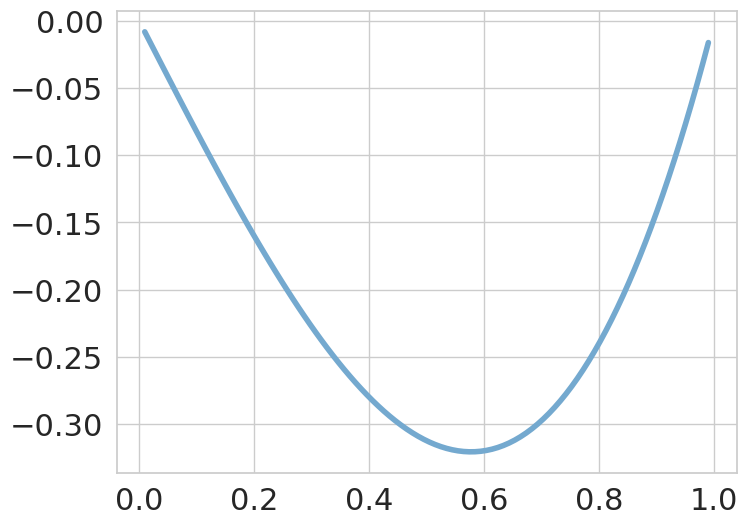

In [3]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", font_scale=2.0)

N = 100
t = jnp.linspace(0, 1, N + 2)[1:-1]
h = 1 / (N + 1)
rhs = f(t)
A = dense_tridiagional_two_points(N)
y = jnp.linalg.solve(A, h**2 * rhs)

plt.figure(figsize=(8, 6))
plt.plot(t, y, color="#74a9cf", lw=4)
plt.show()

Using the above strategy of creating a dense matrix is not a problem when the grid size $n$ is small. However, the majority of the $n^2$ entries are zero and therefore it is wastefull to represent $A$ densely as we increase $n$. Moreover, if we compute $Av$ the majority of the operations needed are multiplications against zero and summing zero elements.

Given the structured present in $A$ we can easily represent it with two numbers $1$ and $-2$ and define a fast MVM as follows:
$$
A v
=
(1)
\begin{pmatrix} 0 \\ v_1 \\ v_2 \\ \vdots \\ v_{n-2} \\ v_{n-1} \end{pmatrix}
+
(-2)
\begin{pmatrix} v_1 \\ v_2 \\ v_3 \\ \vdots \\ v_{n-1} \\ v_{n} \end{pmatrix}
+
(1)
\begin{pmatrix} v_2 \\ v_3 \\ v_4 \\ \vdots \\ v_{n} \\ 0 \end{pmatrix}
$$
which only takes $O(n)$ operations and not $O(n^2)$.
We can implement linear operator notion through

In [4]:
from jax import jit

@jit
def A_linop(v):
    v_low = jnp.concatenate((jnp.array([0]), v[:-1]))
    v_high = jnp.concatenate((v[1:], jnp.array([0])))
    return v_low - 2 * v + v_high

print(f"Diff: {jnp.linalg.norm(A_linop(rhs) - A @ rhs):1.3e}")

Diff: 2.748e-07


In [5]:
N = 1_000
t = jnp.linspace(0, 1, N + 2)[1:-1]
rhs = f(t)
A = dense_tridiagional_two_points(N)
%timeit A @ rhs

85.6 µs ± 1.49 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [6]:
%timeit A_linop(rhs).block_until_ready()

5.65 µs ± 123 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


We see how both representation behave equally when applied to a vector, but that at $n=1$K it is much faster to use the linear operator abstraction.